In [6]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
from torchsummary import summary
from torch.autograd import Variable
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
from collections import Counter
from sklearn.metrics import f1_score
import torch.nn.functional as F
import time
import h5py
import seaborn as sns
plt.rc('font',family='Times New Roman', size=12)

In [7]:
patience = 20
epochs = 300
tra_num = 20000
val_num = 2000
part_num = 100
category = 6
batch_size = 32
density = 1000
num_cell = 32
learning_rate = 3e-4
threshold = 1e-4
realdata_num = 1
start_fm = 64
syn_num = part_num*category
total_num = tra_num + val_num

noise_levels = [0.02, 0.04]
dataFile = './model/tra&val/data{}.mat'
syn_dataFile = './model/syn/data{}.mat'
model_File = 'mymodel.pth'
G = torch.Tensor(np.nan_to_num(h5py.File('./G.mat', 'r')['G'][:])).T

In [8]:
class double_conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=True),
                    nn.BatchNorm2d(out_channels),
                    nn.ELU(inplace=True),
                    nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=True),
                    nn.BatchNorm2d(out_channels),
                    nn.ELU(inplace=True))
        
    def forward(self, x):
        x = self.conv(x)
        return x
        
class Unet(nn.Module):
    
    def __init__(self):
        super(Unet, self).__init__()
             
        self.double_conv1 = double_conv(1, start_fm, 3, 1, 1)
        self.maxpool1 = nn.Sequential(
                        nn.Conv2d(start_fm, start_fm, 2, 2, 0, bias=True),
                        nn.BatchNorm2d(start_fm),
                        nn.ELU(inplace=True))
        self.double_conv2 = double_conv(start_fm, start_fm * 2, 3, 1, 1)
        self.maxpool2 = nn.Sequential(
                    nn.Conv2d(start_fm*2, start_fm*2, 2, 2, 0, bias=True),
                    nn.BatchNorm2d(start_fm*2),
                    nn.ELU(inplace=True))
        self.double_conv3 = double_conv(start_fm * 2, start_fm * 4, 3, 1, 1)
        self.maxpool3 = nn.Sequential(
                    nn.Conv2d(start_fm*4, start_fm*4, 2, 2, 0, bias=True),
                    nn.BatchNorm2d(start_fm*4),
                    nn.ELU(inplace=True))
        self.double_conv4 = double_conv(start_fm * 4, start_fm * 8, 3, 1, 1)
        self.maxpool4 = nn.Sequential(
                nn.Conv2d(start_fm*8, start_fm*8, 2, 2, 0, bias=True),
                nn.BatchNorm2d(start_fm*8),
                nn.ELU(inplace=True))
        self.double_conv5 = double_conv(start_fm * 8, start_fm * 16, 3, 1, 1)
        
        self.t_conv4 = nn.ConvTranspose2d(start_fm * 16, start_fm * 8, 2, 2)
        self.ex_double_conv4 = double_conv(start_fm * 16, start_fm * 8, 3, 1, 1)
        self.t_conv3 = nn.ConvTranspose2d(start_fm * 8, start_fm * 4, 2, 2)
        self.ex_double_conv3 = double_conv(start_fm * 8, start_fm * 4, 3, 1, 1)
        self.t_conv2 = nn.ConvTranspose2d(start_fm * 4, start_fm * 2, 2, 2)
        self.ex_double_conv2 = double_conv(start_fm * 4, start_fm * 2, 3, 1, 1)
        self.t_conv1 = nn.ConvTranspose2d(start_fm * 2, start_fm, 2, 2)
        self.ex_double_conv1 = double_conv(start_fm * 2, start_fm, 3, 1, 1)
        self.ex_double_conv0 = double_conv(start_fm, 16, 3, 1, 1)
        self.final = nn.Sequential(
                    nn.Conv2d(16, 16, kernel_size=1, padding=0, bias=True),
                    nn.BatchNorm2d(16),
                    nn.Sigmoid())

        
    def forward(self, inputs):
        conv1 = self.double_conv1(inputs)
        maxpool1 = self.maxpool1(conv1)
        maxpool1 = nn.Dropout(0.20)(maxpool1)
        conv2 = self.double_conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)
        maxpool2 = nn.Dropout(0.20)(maxpool2)
        conv3 = self.double_conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)
        maxpool3 = nn.Dropout(0.20)(maxpool3)
        conv4 = self.double_conv4(maxpool3)
        maxpool4 = self.maxpool4(conv4)
        maxpool4 = nn.Dropout(0.20)(maxpool4)
        conv5 = self.double_conv5(maxpool4)
        t_conv4 = self.t_conv4(conv5)
        t_conv4 = nn.Dropout(0.20)(t_conv4)
        cat4 = torch.cat([conv4 ,t_conv4], 1)
        ex_conv4 = self.ex_double_conv4(cat4)
        t_conv3 = self.t_conv3(ex_conv4)
        t_conv3 = nn.Dropout(0.20)(t_conv3)
        cat3 = torch.cat([conv3 ,t_conv3], 1)
        ex_conv3 = self.ex_double_conv3(cat3)
        t_conv2 = self.t_conv2(ex_conv3)
        t_conv2 = nn.Dropout(0.20)(t_conv2)
        cat2 = torch.cat([conv2 ,t_conv2], 1)
        ex_conv2 = self.ex_double_conv2(cat2)
        t_conv1 = self.t_conv1(ex_conv2)
        t_conv1 = nn.Dropout(0.20)(t_conv1)
        cat1 = torch.cat([conv1, t_conv1], 1)
        ex_conv1 = self.ex_double_conv1(cat1)
        ex_conv0 = self.ex_double_conv0(ex_conv1)
        result = self.final(ex_conv0)   
        return result

In [9]:
def dice(pred, target):
    smooth = 1
    num = pred.size(0)
    m1 = pred.view(num, -1)  
    m2 = target.view(num, -1)  
    intersection = m1 * m2
    loss = (2. * intersection.sum(1) + smooth) / ((m1*m1).sum(1) + (m2*m2).sum(1) + smooth)
    return loss.sum()/num
    
def my_loss(pre_y, tru_y): 
    loss = 1 - dice(pre_y, tru_y)
    return loss  

In [10]:
def Model(m, w):
    m = m.T
    L, W, H = m.shape
    # Color map: values from low (blue) to high (red); extra color at the end for zeros (gray)
    c = ["#D1FEFE", "#D1FEFE", "#00FEF9", "#00FDFE", "#50FB7F", "#D3F821", "#FFDE00", "#FF9D00", "#F03A00", "#E10000"]
    color_zero = "#000000"  # Gray for zero values

    x, y, z = np.indices((L, W, H))
    model = (x < 0) & (y < 0) & (z < 0)  # Empty model
    color = np.empty(m.shape, dtype=object)

    for i in range(L):
        for j in range(W):
            for k in range(H):
                val = m[i][j][k]
                cube = (x > i-1) & (x <= i) & (y > j-1) & (y <= j) & (z > k-1) & (z <= k)

                if val == 0:
                    color[cube] = color_zero
                    model = model | cube
                elif val >= w:
                    index = min(int(round(10 * val)) - 1, len(c) - 1)
                    color[cube] = c[index]
                    model = model | cube

    plt_model(model, color)



def plt_model(model, facecolors='r'):
    fig = plt.figure(figsize = (8, 4))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(model, facecolors=facecolors, edgecolors='w', linewidth=0.5)
    plt.xticks(np.arange(0, 33, 1), ('0', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '400', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '800', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '1200', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '1600'))
    ax.set_xlabel('Easting (m)', labelpad=1)
    plt.yticks(np.arange(0, 33, 1), ('0', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '400', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '800', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '1200', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '1600'))
    ax.set_ylabel('Northing (m)', labelpad=0)
    ax.set_zticks(np.arange(0, 17, 1))
    ax.set_zticklabels(['0', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '400', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '800'])
    ax.set_zlabel('Depth (m)', labelpad=-3)
    ax.invert_zaxis()
    ax.xaxis.set_tick_params(pad=-2)
    ax.yaxis.set_tick_params(pad=-2)
    ax.zaxis.set_tick_params(pad=0)
    plt.show()

def plt_m(y, color='b'):
    x = range(1, len(y)+1)
    plt.xlim(-100, 16500)
    plt.ylim(0, 1.01)
    plt.xticks(np.arange(0, 16500, step=1024), fontsize=4)
    for i in range(len(y)):
        if y[i]==1:
            plt.scatter(x[i], y[i],linewidths=0.001)
    plt.plot(x, y, linewidth=0.8, color=color, linestyle=":")
    
def plt_g(g, my_levels):
    color = ('#00008F', '#0030FF', '#10FFEF', '#DFFF20', '#FF5000', '#800000')
    cmap = colors.ListedColormap(color)
    g = np.where(g > 0, g, 0)
    cs = plt.contourf(g, my_levels, cmap=cmap)
    plt.contour(cs, colors='k', linewidths=0.7)
    fig.colorbar(cs)
    plt.xticks(np.arange(0, 32, 7.75), ('0', '400', '800', '1200', '1600'))
    plt.xlabel('Easting (m)')
    plt.yticks(np.arange(0, 32, 7.75), ('0', '400', '800', '1200', '1600'))
    plt.ylabel('Northing (m)')
    plt.tick_params(bottom=False, top=False, left=False, right=False)
    
def colorma():
    cdict = ["#F2F2F2", "#D1FEFE", "#00FEF9", "#00FDFE", "#50FB7F", "#D3F821", "#FFDE00", "#FF9D00", "#F03A00", "#E10000"] 
    return colors.ListedColormap(cdict, 'indexed')
    
def plot_xoy(model):
    I = []
    for i, j in enumerate(tru_model):
        if j.max() > 0:
            I.append(i)
    
    index = (I[0] + I[-1])//2

    ax = plt.gca()
    model = np.around(model, decimals=1)
    plt.imshow(model[index], cmap=colorma())
    ax.invert_yaxis()
    plt.xticks(np.arange(-0.5, 32.5, 1), ('0', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '400', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '800', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '1200', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '1600'))
    plt.xlabel('Easting (m)')
    plt.yticks(np.arange(-0.5, 32.5, 1), ('0', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '400', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '800', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '1200', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '1600'))
    plt.ylabel('Northing (m)')
    plt.grid()
    plt.colorbar(shrink=1, aspect=30)

In [11]:
import scipy.io
import numpy as np

x = []
y = []

for i in range(total_num):
    data = scipy.io.loadmat(dataFile.format(i))  # .mat file
    m = data['m'].flatten() / density
    d = data['d'].flatten()
    d = np.nan_to_num(d)
    x.append(d.reshape(1, num_cell, num_cell))            # d: (1, 32, 32)
    y.append(m.reshape(16, num_cell, num_cell))           # m: (16, 32, 32)

syn_x = []
syn_y = []

for i in range(syn_num):
    data = scipy.io.loadmat(syn_dataFile.format(i))  # .mat file
    m = data['m'].flatten() / density
    d = data['d'].flatten()
    d = np.nan_to_num(d)
    syn_x.append(d.reshape(1, num_cell, num_cell))
    syn_y.append(m.reshape(16, num_cell, num_cell))

tra_x = x[:tra_num]
tra_y = y[:tra_num]
val_x = x[-val_num:]
val_y = y[-val_num:]


In [12]:
syn_x[0].min()


np.float64(2.663214102614615)

In [13]:
f=syn_x[0].max()
f

np.float64(11.115284426347669)

In [42]:
# for j in noise_levels:
#     for i in range(tra_num):
#         noise_x = tra_x[i] + j*tra_x[i].max()*np.random.normal(0, 1, (1, num_cell, num_cell))
#         tra_x.append(noise_x)
#         tra_y.append(tra_y[i])

#     for i in range(val_num):
#         noise_x = val_x[i] + j*val_x[i].max()*np.random.normal(0, 1, (1, num_cell, num_cell))
#         val_x.append(noise_x)
#         val_y.append(val_y[i])

#     for i in range(syn_num):
#         noise_x = syn_x[i] + j*syn_x[i].max()*np.random.normal(0, 1, (1, num_cell, num_cell))
#         syn_x.append(noise_x)
#         syn_y.append(syn_y[i])

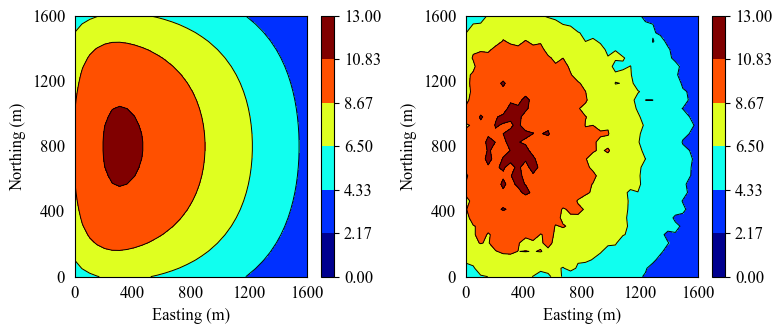

In [15]:
d = syn_x[0]
noise_d = d + np.array(noise_levels[1]*max(d))*(np.random.normal(0, 1, d.shape))
noise_d = np.where(noise_d > 0, noise_d, 0)

fig = plt.figure(figsize=(8, 3.5))
my_levels = np.linspace(0., 13, 7)
plt.subplot(121)
plt_g(d[0], my_levels)

plt.subplot(122)
plt_g(noise_d[0], my_levels)
plt.tight_layout()
plt.show()

In [16]:
print(np.shape(tra_x), np.shape(tra_y))
print(np.shape(val_x), np.shape(val_y))
print(np.shape(syn_x), np.shape(syn_y))

(20000, 1, 32, 32) (20000, 16, 32, 32)
(2000, 1, 32, 32) (2000, 16, 32, 32)
(600, 1, 32, 32) (600, 16, 32, 32)


In [17]:
tra_idxs = list(range(len(tra_x)))
val_idxs = list(range(len(val_x)))
# np.random.shuffle(tra_idxs)
# np.random.shuffle(val_idxs)
syn_idxs = list(range(len(syn_x)))

In [18]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,images,train=True, masks=None):
        self.train = train
        self.images = images
        if self.train:
            self.masks = masks
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
        return (image, mask)
    
tra = Dataset(np.array(tra_x).astype(np.float32)[tra_idxs], train=True, masks=np.array(tra_y).astype(np.float32)[tra_idxs])
val = Dataset(np.array(val_x).astype(np.float32)[val_idxs], train=True, masks=np.array(val_y).astype(np.float32)[val_idxs])
syn = Dataset(np.array(syn_x).astype(np.float32)[syn_idxs], train=True, masks=np.array(syn_y).astype(np.float32)[syn_idxs])

tra_loader = torch.utils.data.DataLoader(dataset=tra, batch_size=batch_size, shuffle=False, pin_memory=False)
val_loader = torch.utils.data.DataLoader(dataset=val, batch_size=batch_size, shuffle=False, pin_memory=False)
syn_loader = torch.utils.data.DataLoader(dataset=syn, batch_size=batch_size, shuffle=False, pin_memory=False)

In [19]:
model = Unet()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
summary(model, input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]             640
       BatchNorm2d-2           [-1, 64, 64, 64]             128
               ELU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          36,928
       BatchNorm2d-5           [-1, 64, 64, 64]             128
               ELU-6           [-1, 64, 64, 64]               0
       double_conv-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 32, 32]          16,448
       BatchNorm2d-9           [-1, 64, 32, 32]             128
              ELU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]          73,856
      BatchNorm2d-12          [-1, 128, 32, 32]             256
              ELU-13          [-1, 128, 32, 32]               0
           Conv2d-14          [-1, 128,

In [20]:
mean_tra_losses = []
mean_val_losses = []
mean_syn_losses = []
val_data = []
syn_data = []

start = time.time()
epoch = 0
while epoch <= epochs:
    tra_losses = []
    val_losses = []
    syn_losses = []
    
    model.train()
    for images, masks in tra_loader:   
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        optimizer.zero_grad()
        outputs = model(images)      
        loss = my_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        tra_losses.append(loss.data)
        
    model.eval() 
    for images, masks in val_loader:
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        with torch.no_grad():
            outputs = model(images)
            val_loss = my_loss(outputs, masks)
            val_losses.append(val_loss.data)  
            if (epoch > patience and abs(mean_val_losses[-patience] - mean_val_losses[-1]) < threshold) or epoch == epochs:
                val_data.extend([[outputs, masks, images]])
                
    for images, masks in syn_loader:
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        with torch.no_grad():
            outputs = model(images)
            syn_loss = my_loss(outputs, masks)
            syn_losses.append(syn_loss.data)  
            if (epoch > patience and abs(mean_val_losses[-patience] - mean_val_losses[-1]) < threshold) or epoch == epochs:
                syn_data.extend([[outputs, masks, images]])      

    # Convert to CPU and extract float before storing and printing
    mean_tra = torch.mean(torch.stack(tra_losses)).cpu().item()
    mean_val = torch.mean(torch.stack(val_losses)).cpu().item()
    mean_syn = torch.mean(torch.stack(syn_losses)).cpu().item()

    mean_tra_losses.append(mean_tra)
    mean_val_losses.append(mean_val)
    mean_syn_losses.append(mean_syn)

    print('Epoch: %d. Tra Loss: %0.4f. Val Loss: %0.4f. Syn Loss: %0.4f' % (
        epoch, mean_tra, mean_val, mean_syn
    ))
    
    if epoch > patience and abs(mean_val_losses[-patience] - mean_val_losses[-1]) < threshold:
        torch.save(model.state_dict(), model_File)
        print("Early stopping")
        break
        
    epoch += 1

end = time.time()
run_time = end - start
print(run_time)

torch.save(model.state_dict(), model_File)
print("Model saved after final epoch")

Epoch: 0. Tra Loss: 0.1406. Val Loss: 0.1171. Syn Loss: 0.1657
Epoch: 1. Tra Loss: 0.1017. Val Loss: 0.0934. Syn Loss: 0.1509
Epoch: 2. Tra Loss: 0.0786. Val Loss: 0.0677. Syn Loss: 0.1208
Epoch: 3. Tra Loss: 0.0613. Val Loss: 0.0550. Syn Loss: 0.1027
Epoch: 4. Tra Loss: 0.0485. Val Loss: 0.0576. Syn Loss: 0.0776
Epoch: 5. Tra Loss: 0.0386. Val Loss: 0.0369. Syn Loss: 0.0859
Epoch: 6. Tra Loss: 0.0314. Val Loss: 0.0270. Syn Loss: 0.0756
Epoch: 7. Tra Loss: 0.0252. Val Loss: 0.0248. Syn Loss: 0.0693
Epoch: 8. Tra Loss: 0.0205. Val Loss: 0.0189. Syn Loss: 0.0778
Epoch: 9. Tra Loss: 0.0168. Val Loss: 0.0175. Syn Loss: 0.0656
Epoch: 10. Tra Loss: 0.0139. Val Loss: 0.0128. Syn Loss: 0.0629
Epoch: 11. Tra Loss: 0.0114. Val Loss: 0.0125. Syn Loss: 0.0563
Epoch: 12. Tra Loss: 0.0095. Val Loss: 0.0194. Syn Loss: 0.0566
Epoch: 13. Tra Loss: 0.0084. Val Loss: 0.0084. Syn Loss: 0.0539
Epoch: 14. Tra Loss: 0.0069. Val Loss: 0.0062. Syn Loss: 0.0486
Epoch: 15. Tra Loss: 0.0057. Val Loss: 0.0056. Syn

In [21]:
val_data = []
syn_data = []
model.load_state_dict(torch.load(model_File))
model.eval() 
for images, masks in val_loader:
    with torch.no_grad():
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        outputs = model(images)
        val_data.extend([[outputs, masks, images]])

for images, masks in syn_loader:
    with torch.no_grad():
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        outputs = model(images)
        syn_data.extend([[outputs, masks, images]])  

C:\Users\Suhani\AppData\Local\Temp\ipykernel_19592\131702450.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_File))


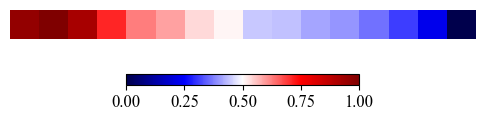

In [22]:
filters = model.state_dict()['final.1.weight'].cpu()
f_min, f_max = filters.min(), filters.max()
filters = (filters -f_min)/(f_max-f_min)
plt.figure(figsize=(6, 3))
plt.axis('off')
plt.imshow(filters.reshape(1, 16), cmap='seismic')
plt.colorbar(shrink=0.5, aspect=20, orientation='horizontal')
plt.show()

In [23]:
val_truth = []
val_predict = [] 
val_truth_d = []

for q in val_data:
    for j in q[1]:
        val_truth.append(j.detach().cpu().reshape(1, 16384)[0].numpy())
    for j in q[0]:
        val_predict.append(j.detach().cpu().reshape(1, 16384)[0].numpy())
    for j in q[2]:
        val_truth_d.append(j.detach().cpu().reshape(1, 1024)[0].numpy())

syn_truth = []
syn_predict = []
syn_truth_d = []

for q in syn_data:
    for j in q[1]:
        syn_truth.append(j.detach().cpu().reshape(1, 16384)[0].numpy())
    for j in q[0]:
        syn_predict.append(j.detach().cpu().reshape(1, 16384)[0].numpy())
    for j in q[2]:
        syn_truth_d.append(j.detach().cpu().reshape(1, 1024)[0].numpy())


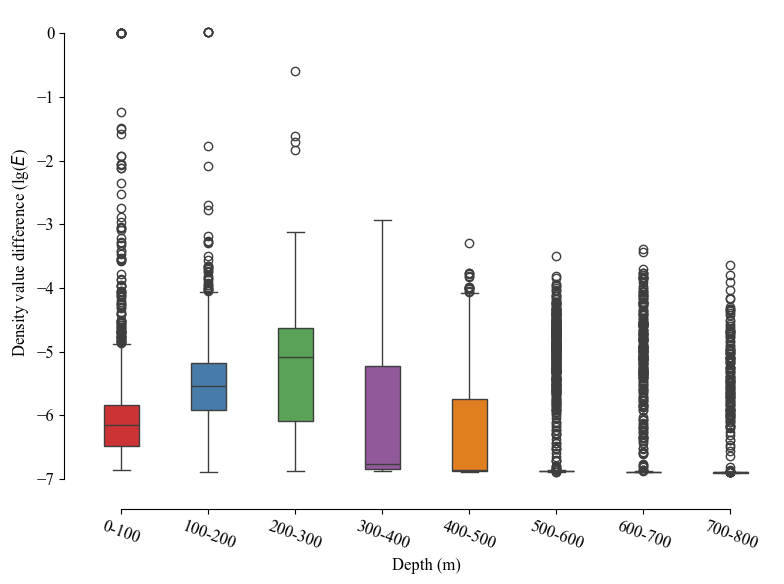

In [24]:
ddiff = np.zeros((val_num, 8))
for j in range(0, 16, 2):
    n = int(0.5*j)
    for i in range(val_num):
        a = val_predict[i].reshape(16, num_cell, num_cell)[j: j+2]
        b = val_truth[i].reshape(16, num_cell, num_cell)[j: j+2]
        ddiff[i, n] = np.mean(np.power(a-b, 2)+1e-3)/np.mean(np.power(b, 2)+1e-3)
ddiff = pd.DataFrame(ddiff)
ddiff.columns = ['0-100','100-200', '200-300', '300-400', '400-500', '500-600', '600-700', '700-800']
ddiff = np.log(ddiff)

plt.figure(figsize=(8, 6))
sns.boxplot(data=ddiff, width=0.4, palette='Set1')
sns.despine(offset=10, trim=True)
plt.xticks(rotation=-20)
plt.xlabel('Depth (m)')
plt.ylabel('Density value difference (lg($\it{E}$)')
plt.tight_layout()
plt.show()

In [25]:
val_rel = []
val_R_2 = []
syn_rel = []
syn_R_2 = []
for i in range(len(val_x)):
    val_rel.append(np.linalg.norm(np.array(val_predict[i]) - np.array(val_truth[i]), 2)/np.linalg.norm(np.array(val_truth[i]), 2))
    tru_d = val_truth_d[i].reshape(1024, 1)
    pre_d = np.asmatrix(G)*np.asmatrix(density*val_predict[i].reshape(16384, 1))
    val_R_2.append(1- np.sum(np.power(tru_d - pre_d, 2))/np.sum(np.power(tru_d - np.mean(tru_d), 2)))

E = [np.array(val_rel).mean()]
R_2 = [np.array(val_R_2).mean()]

for i in range(len(syn_x)):
    syn_rel.append(np.linalg.norm(np.array(syn_predict[i]) - np.array(syn_truth[i]), 2)/np.linalg.norm(np.array(syn_truth[i]), 2))
    tru_d = syn_truth_d[i].reshape(1024, 1)
    pre_d = np.asmatrix(G)*np.asmatrix(density*syn_predict[i].reshape(16384, 1))
    syn_R_2.append(1 - np.sum(np.power(tru_d - pre_d, 2))/np.sum(np.power(tru_d - np.mean(tru_d), 2)))

for i in range(category):
    E.append(np.array(syn_rel)[part_num*i: part_num*(i+1)].mean())
    R_2.append(np.array(syn_R_2)[part_num*i: part_num*(i+1)].mean())

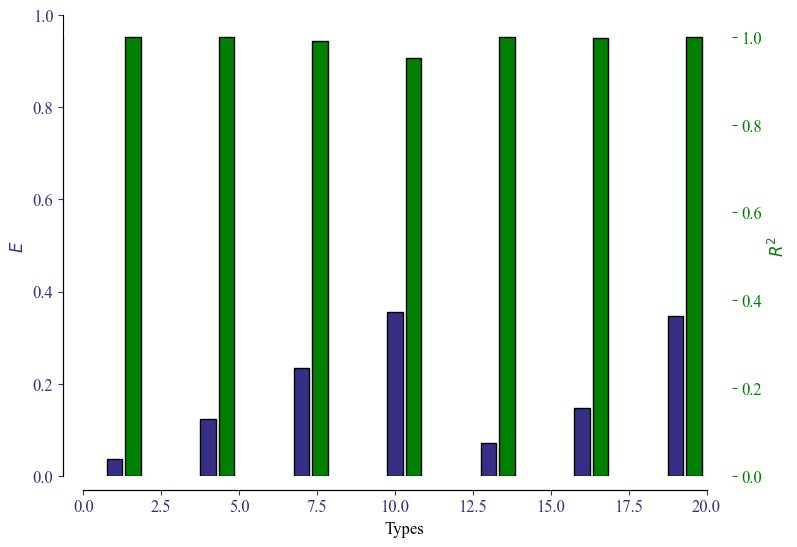

In [26]:
x1 = [1, 4, 7, 10, 13, 16, 19]
x2 = [1.6, 4.6, 7.6, 10.6, 13.6, 16.6, 19.6]
c = ['#362F85', 'g']
width = 0.5
fig = plt.figure(figsize=(8, 5.5))
ax1 = fig.add_subplot()
ax1.bar(x1, E, width, color=c[0], edgecolor='k')
plt.ylim(0, 1)
plt.xlabel("Types")
plt.ylabel("$E$", color=c[0])
ax1.tick_params(colors=c[0])
ax2 = ax1.twinx()
ax2.bar(x2, R_2, width, color=c[1], edgecolor='k')
ax2.set_ylabel("$R^2$", color=c[1])
ax2.tick_params(colors=c[1])
plt.tight_layout()
sns.despine(offset=10, trim=True)
plt.show()

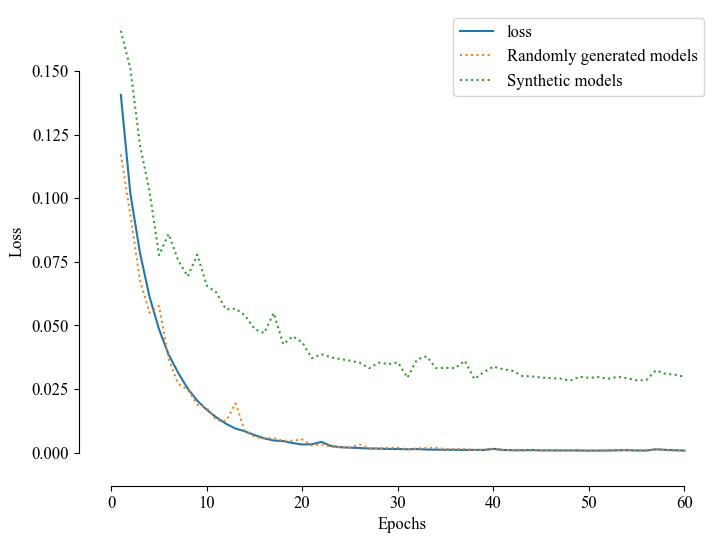

In [27]:
plt.figure(figsize=(8, 6))
min_len = min(len(mean_tra_losses), len(mean_val_losses), len(mean_syn_losses))
X = range(1, min_len+1)
plt.plot(X, mean_tra_losses)
plt.plot(X, mean_val_losses, linestyle=':')
plt.plot(X, mean_syn_losses, linestyle=':')
sns.despine(offset=10, trim=True)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["loss", "Randomly generated models", "Synthetic models"], loc='best')
plt.show()

In [29]:
index = 2
m1 = val_truth[index]
m2 = val_predict[index]
m3 = (m2 > 0.5).astype(np.uint8)
tru_g = val_truth_d[index]
plt.figure(figsize=(8, 3))
plt.subplot(3,1,1)
plt_m(m1, 'r')
plt.subplot(3, 1, 2)
plt_m(m2)
plt.subplot(3, 1, 3)
plt_m(m3)

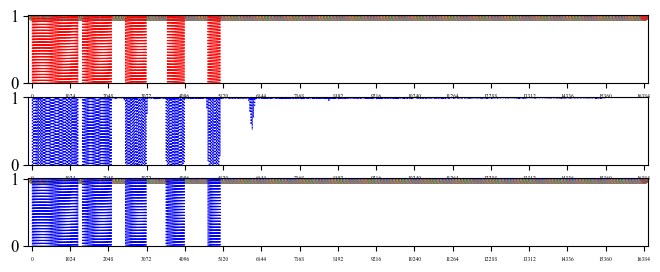

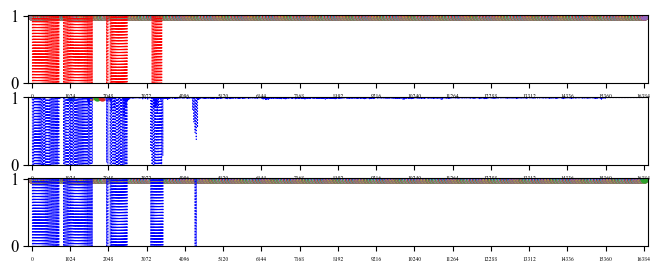

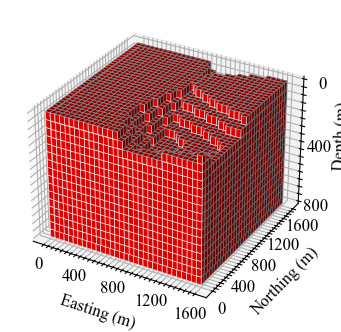

In [30]:
tru_model = m1.reshape(16, num_cell, num_cell)
truth_model = tru_model.T > 0
plt_model(truth_model)

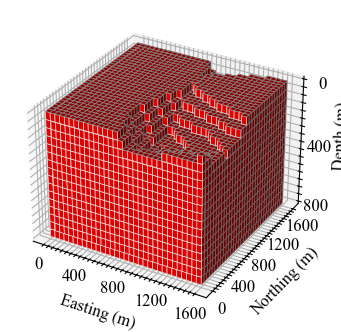

In [31]:
predict_model = m3.reshape(16, num_cell, num_cell)
predict_model = predict_model.T > 0
plt_model(predict_model)

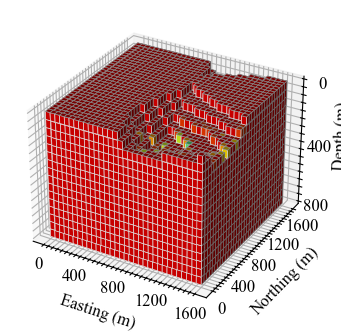

In [32]:
pre_model = m2.reshape(16, num_cell, num_cell)
w = 0.5
Model(pre_model, w)

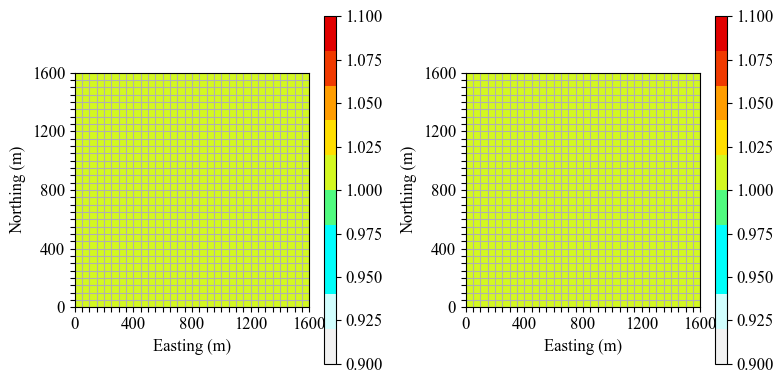

In [33]:
plt.figure(figsize = (8, 4))
plt.subplot(121)
plot_xoy(tru_model)
plt.subplot(122)
plot_xoy(pre_model)
plt.tight_layout()
plt.show()

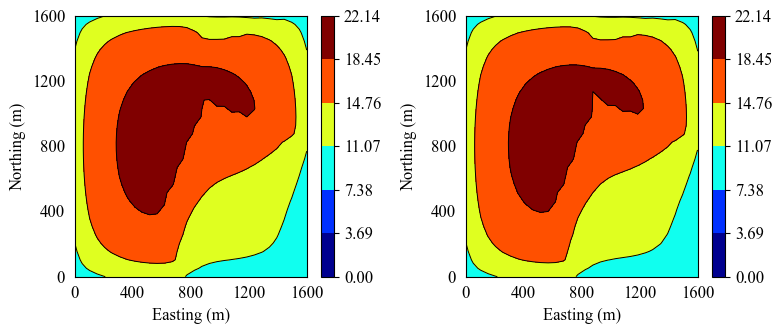

In [34]:
pre_m = density*np.reshape(m2, (16384, 1))
pre_g = np.asmatrix(G) * np.asmatrix(pre_m)
pre_g = np.reshape(pre_g, (num_cell, num_cell))
tru_g = np.reshape(tru_g, (32, 32))
my_levels = np.linspace(0., 1.1*round(tru_g.max(), 2), 7)

fig = plt.figure(figsize=(8, 3.5))
plt.subplot(121)
plt_g(tru_g, my_levels)                                                                                                                                                                                                                                                                                                                                                                                                                                                            
plt.subplot(122)
plt_g(pre_g, my_levels)
plt.tight_layout()
plt.show()